In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import pandas as pd

from iqradre.detect.pred import BoxesPredictor

from iqradre.recog.prod import TextPredictor
from iqradre.recog.prod import utils as text_utils

from transformers import BertTokenizer
from iqradre.extract.prod.prod import Extractor

import matplotlib.pyplot as plt
from iqradre.detect.ops import boxes as boxes_ops
from iqradre.detect.ops import box_ops


In [3]:
craft_weight = f'../weights/detect/craft_ktp_ohem.pth.tar'
crnn_path = '../weights/recog/ocrnet_pretrained_ktp.pth'
layoutlm_path = '../weights/extract/layoutlm_v2_ktp_1606753021.pth'

In [4]:
predictor = BoxesPredictor(weight_path=craft_weight, device='cuda:0')
text_pred = TextPredictor(weight_path=crnn_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
extract = Extractor(tokenizer=tokenizer, weight=layoutlm_path)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [69]:
%%time
impath = '/data/idcard/combined/1606753021/153062_image.jpg'
# impath = transform.do_autocrop_deskew(impath)
result = predictor.predict_word_boxes(impath, text_threshold=0.3, low_text=0.2)
polys, boxes, images_patch, img, score_text, score_link, ret_score_text = result

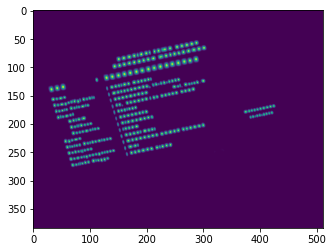

In [79]:
plt.imshow(score_text)

In [70]:
boxes_list = box_ops.batch_box_coordinate_to_xyminmax(boxes, to_int=True).tolist()   
boxes_list[0]

[493.0, 119.0, 591.0, 145.0]

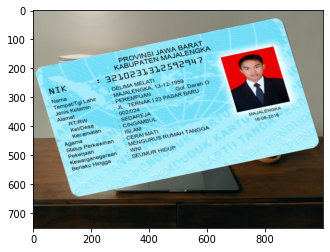

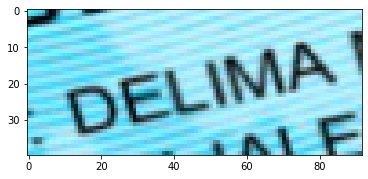

[265.0, 262.0, 348.0, 283.0]


In [71]:
idx = 11
plt.imshow(img);plt.show()
plt.imshow(images_patch[idx]);plt.show()
print(boxes_list[idx])

In [72]:
%%time
text_list = text_pred.predict(images_patch)

CPU times: user 6.25 s, sys: 2.45 ms, total: 6.26 s
Wall time: 804 ms


In [73]:
text_list

['BERAKU',
 'DOSAR/YIK',
 'ADARANTO',
 'PRYNNU1',
 'KGOPATEN',
 'KRADTON',
 'AMELATI',
 'LE',
 'Ax-12-1989',
 '011',
 'parah',
 '.EELINAS',
 'NIK/4.H',
 'go.',
 'AFLA',
 'aw',
 "'ARU",
 'KALY',
 'S.PASARAT',
 'Lin',
 '23-0',
 'Nama',
 'TLabit',
 'AM',
 'TERNAKEN',
 'Tempatedit',
 'Pawas',
 'JLUA',
 'Kelamin',
 '400A4AL',
 'SATIN',
 '0020044',
 'Jenis/DD',
 '0700514',
 'Awa',
 'Re-co2019-',
 'Alamata',
 'SREAMBU',
 'RTRR',
 'ET',
 'Keloesa',
 'at',
 'ITANGGA',
 'ISLANGN',
 'Kecamaan',
 'AMATL_',
 'RUMAHT',
 'LEN',
 'CERAG',
 'OENGURUSE',
 'TAWAN',
 'Agama',
 'Perkawinan',
 'L.n',
 'KHIDUP',
 'Status',
 'WNYTT',
 'GAR',
 'SEUMURUS',
 'Pekerjaan',
 'TERPResaan',
 'L2',
 'Hingga',
 'Berlaku']

In [74]:
data_annoset = text_utils.build_annoset(text_list, boxes)

In [75]:
data, clean = extract.predict(data_annoset)

In [76]:
data

{'provinsi': '',
 'kabupaten': '',
 'nik': 'KRADTON',
 'nama': 'BERAKU LE TLabit Alamata RTRR Keloesa Kecamaan Agama Perkawinan Status Pekerjaan TERPResaan Hingga',
 'ttl': '',
 'gender': '',
 'goldar': '',
 'alamat': 'PRYNNU1 KGOPATEN AMELATI .EELINAS aw AFLA Lin 23-0 AM KALY Pawas TERNAKEN JLUA SATIN Awa 0700514 ET SREAMBU at ISLANGN AMATL_ LEN CERAG TAWAN OENGURUSE L.n WNYTT GAR SEUMURUS L2',
 'rtrw': '0020044',
 'kelurahan': 'parah Ax-12-1989 S.PASARAT KHIDUP',
 'kecamatan': "'ARU 400A4AL ITANGGA",
 'agama': 'go.',
 'perkawinan': '',
 'pekerjaan': 'DOSAR/YIK RUMAHT',
 'kewarganegaraan': '',
 'berlaku': '',
 'sign_place': '',
 'sign_date': '011 Re-co2019-'}

In [77]:
pd.DataFrame(clean)

,words,bboxes,tokens,labels,gseq,wseq
0,BERAKU,"[493.0, 119.0, 591.0, 145.0]",berak,I-VAL_NAMA,0,0
1,BERAKU,"[493.0, 119.0, 591.0, 145.0]",##u,L-VAL_KCM,0,1
2,DOSAR/YIK,"[434.0, 153.0, 618.0, 180.0]",dosa,B-VAL_KRJ,1,0
3,DOSAR/YIK,"[434.0, 153.0, 618.0, 180.0]",##r,I-VAL_KRJ,1,1
4,DOSAR/YIK,"[434.0, 153.0, 618.0, 180.0]",/,I-VAL_KRJ,1,2
...,...,...,...,...,...,...
146,TERPResaan,"[121.0, 515.0, 294.0, 537.0]",##aan,L-VAL_NAMA,60,2
147,L2,"[326.0, 500.0, 334.0, 514.0]",l,I-VAL_ADR,61,0
148,L2,"[326.0, 500.0, 334.0, 514.0]",##2,I-VAL_ADR,61,1
149,Hingga,"[201.0, 520.0, 272.0, 541.0]",hingga,I-VAL_NAMA,62,0
